In [1]:
import numpy as np
from dataclasses import dataclass
from sklearn.datasets import load_diabetes
import pandas as pd

/var/folders/1j/chhd52wn0z97rq9skbstg0_00000gn/T/ipykernel_4520/2344207688.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [96]:
@dataclass
class SplitData:
    """
    A dataclass for representing the result of a data split at a Decision Tree node, including details necessary for propagating splits across the tree.

    Attributes:
        left_partition_mask (np.ndarray): A boolean mask indicating samples allocated to the left child node based on the split.
        right_partition_mask (np.ndarray): A boolean mask indicating samples allocated to the right child node based on the split.
        left_count (int): Number of samples in the left partition, facilitating efficient calculation of statistics or further splits.
        right_count (int): Number of samples in the right partition, facilitating efficient calculation of statistics or further splits.
        feat_index (int): Index of the feature used for splitting, enabling traceability of the decision path within the tree.
        cost (float): The cost or impurity reduction achieved by this split, used to assess the quality of the split.
        thresh (float): Threshold value for the feature at this split, determining the boundary between left and right partitions.
        
    This structure is crucial for the iterative construction and analysis of Decision Trees, where each node's decision to split data affects subsequent nodes' decisions.
    """
    left_partition_mask: np.ndarray
    right_partition_mask: np.ndarray
    left_count: int
    right_count: int 
    feat_index: int 
    cost: float 
    thresh: float

    def __str__(self):
        cost_rounded = float(self.cost)
        cost_rounded = round(cost_rounded, 3)

        thresh_rounded = float(self.thresh)
        thresh_rounded = round(thresh_rounded, 3)

        return ', '.join([
            f'cost={cost_rounded}', 
            f'feature_index={self.feat_index}', 
            f'left_count={self.left_count}',
            f'right_count={self.right_count}', 
            f'thresh={thresh_rounded}',
        ])
    

class TreeNode:

    def compute_out_per_node(self, X, y):
        output_mask = X[:, self.feat_index] <= self.thresh
        num_samples = np.sum(output_mask.astype(np.int32))
        self.out_per_node = np.sum(y * output_mask) / num_samples
        # self.out_per_node = np.mean(y * output_mask)
        # output_mask = X[:, self.feat_index]

    def __init__(self, 
                    X : np.array, 
                    y : np.array,
                    max_depth=5, 
                    min_leaves=1,
                    depth_index=0,
                    width_index=0,
                    node_type='init_node',
                    partition=None,
                    
                 ):
        
        self.depth_index = depth_index
        self.width_index = width_index

        self.max_depth = max_depth 
        self.min_leaves = min_leaves

        if partition is None:
            self.partition = np.ones((y.shape[0],))
        else:
            self.partition = partition

        split_data = self.split_by_min_feat_thresh(X, y, partition)
        
        next_depth = self.depth_index + 1
        is_not_max_depth = self.max_depth > next_depth        
        left_is_not_max_leaves = min_leaves < split_data.left_count
        right_is_not_max_leaves = min_leaves < split_data.right_count
        
        grow_left = is_not_max_depth and left_is_not_max_leaves
        grow_right = is_not_max_depth and right_is_not_max_leaves

        self.feat_index = split_data.feat_index


        self.thresh = split_data.thresh
        self.node_type = node_type
        self.compute_out_per_node(X, y)

        print(f'[{self.depth_index}/{self.max_depth}] out_per_node={round(float(self.out_per_node), 3)},node_type={node_type}, grow_left={grow_left}, grow_right={grow_right}, {split_data}')

        self.left_node, self.right_node = None, None
        
        if grow_left:
            self.left_node = TreeNode(
                                X, y, 
                                max_depth=max_depth, 
                                min_leaves=min_leaves,
                                depth_index=next_depth,
                                width_index=self.width_index,
                                node_type='left_node',
                                partition=split_data.left_partition_mask
                            )

        if grow_right:
            self.right_node = TreeNode(
                                X,y,
                                max_depth=max_depth,
                                min_leaves=min_leaves,
                                depth_index=next_depth,
                                width_index=self.width_index + 1,
                                node_type='right_node',
                                partition=split_data.right_partition_mask
                            )
    
    def split_by_min_thresh(self, X, y, feat_index, partition_mask=None):
        thresh = np.unique(X[:,feat_index]).reshape(1,-1)
        selected_feat = X[:,feat_index].reshape(-1,1)
        is_left_sampler = (selected_feat <= thresh)
        is_right_sampler = ~is_left_sampler

        if partition_mask is not None:
            partition_mask = np.hstack(is_left_sampler.shape[1] * [ partition_mask.reshape(-1,1) ])
            is_left_sampler = is_left_sampler & partition_mask
            is_right_sampler = is_right_sampler & partition_mask

        stacked_targets = np.hstack([y.reshape(-1,1)] * is_left_sampler.shape[1])
        left_sampled, right_sampled = is_left_sampler * stacked_targets, is_right_sampler * stacked_targets

        n_samples_left, n_samples_right = np.sum(is_left_sampler, axis=0), np.sum(is_right_sampler, axis=0)

        with np.errstate(divide='ignore', invalid='ignore'):
            left_samples_mean = np.where(n_samples_left == 0, 0, np.sum(left_sampled, axis=0) / n_samples_left)
            right_samples_mean = np.where(n_samples_right == 0, 0, np.sum(right_sampled, axis=0) / n_samples_right)
        
        var_left = is_left_sampler * (left_sampled - left_samples_mean.reshape(1,-1)) ** 2
        var_right = is_right_sampler * (right_sampled - right_samples_mean.reshape(1,-1)) ** 2

        with np.errstate(divide='ignore', invalid='ignore'):
            var_left = np.where(n_samples_left == 0, 0, np.sum(var_left, axis=0) / n_samples_left)
            var_right = np.where(n_samples_right == 0, 0, np.sum(var_right, axis=0) / n_samples_right)

        total_samples = left_sampled.shape[0]
        assert total_samples == right_sampled.shape[0], 'wrong total samples'

        ratio_left, ratio_right = n_samples_left / total_samples, n_samples_right / total_samples
        thresh_cost = ratio_left * var_left + ratio_right * var_right
        min_thresh_index = np.argmin(thresh_cost)

        return SplitData(
            left_partition_mask=is_left_sampler[:, min_thresh_index],
            right_partition_mask=is_right_sampler[:, min_thresh_index],
            left_count=np.sum(is_left_sampler[:, min_thresh_index]),
            right_count=np.sum(is_right_sampler[:, min_thresh_index]),
            feat_index=feat_index,
            cost=np.min(thresh_cost),
            thresh=thresh.reshape(-1)[min_thresh_index] 
        )

    def split_by_min_feat_thresh(self, X, y, partition):
        feat_count = X.shape[1]
        min_split_data = self.split_by_min_thresh(X, y, 0)

        for feat_index in range(1, feat_count):
            split_data = self.split_by_min_thresh(X, y, feat_index, partition)
            if min_split_data.cost > split_data.cost:
                min_split_data = split_data

        return min_split_data
    
    def prediction_per_node(self, X, y_preds):
        prediction_mask = X[:,self.feat_index] <= self.thresh
        prediction_mask = prediction_mask * self.partition
        prediction_indices = np.nonzero(prediction_mask)[0]
        print(f'[(d={self.depth_index}, w={self.width_index})] node_type = {self.node_type}', prediction_indices)
        
        no_left_child = self.left_node is None
        no_right_child = self.right_node is None
        if no_right_child or no_left_child:
            y_preds[prediction_indices] = self.out_per_node
        
        if self.left_node is not None:
            self.left_node.prediction_per_node(X, y_preds)
        
        if self.right_node is not None:
            self.right_node.prediction_per_node(X, y_preds)




In [97]:

from sklearn.datasets import load_diabetes
import pandas as pd

class DumbDecisionTreeRegressor:
    def __init__(
            self,
            max_depth=5, 
            min_leaves=1, 
        ):

        self.max_depth=max_depth
        self.min_leaves=min_leaves


    def fit(self, X, y):
        self.node = TreeNode(X, y, 
                             max_depth=self.max_depth, 
                             min_leaves=self.min_leaves, 
                             depth_index=0
                            )
        

    def predict(self, X):
        y_preds = np.zeros((X.shape[0],))
        self.node.prediction_per_node(X, y_preds)
        return y_preds
        

In [98]:
data = load_diabetes()
X,y = data['data'], data['target']
max_depth = 20
min_leaves = 1

model = DumbDecisionTreeRegressor(max_depth=max_depth, min_leaves=min_leaves)
model.fit(X,y)

[0/20] out_per_node=109.986,node_type=init_node, grow_left=True, grow_right=True, cost=4201.076, feature_index=8, left_count=218, right_count=224, thresh=-0.004
[1/20] out_per_node=119.956,node_type=left_node, grow_left=True, grow_right=True, cost=1262.777, feature_index=2, left_count=171, right_count=47, thresh=0.006
[2/20] out_per_node=169.152,node_type=left_node, grow_left=True, grow_right=True, cost=766.899, feature_index=6, left_count=87, right_count=84, thresh=0.019
[3/20] out_per_node=148.226,node_type=left_node, grow_left=True, grow_right=True, cost=480.771, feature_index=4, left_count=85, right_count=2, thresh=0.049
[4/20] out_per_node=149.021,node_type=left_node, grow_left=True, grow_right=True, cost=451.92, feature_index=1, left_count=39, right_count=46, thresh=-0.045
[5/20] out_per_node=118.812,node_type=left_node, grow_left=True, grow_right=True, cost=225.88, feature_index=3, left_count=21, right_count=18, thresh=-0.037
[6/20] out_per_node=94.377,node_type=left_node, grow_

[(d=0, w=0)] node_type = init_node [  1   4   5   6   7   8  10  11  12  14  18  19  20  21  22  24  26  27
  30  31  33  34  41  42  43  45  46  47  48  50  52  53  54  55  57  60
  62  63  64  67  68  69  70  73  76  77  79  81  82  83  84  85  86  88
  89  90  93  94  98 101 102 103 104 105 106 107 109 110 111 112 120 124
 126 128 131 132 133 134 136 140 143 145 148 150 151 153 156 158 160 162
 163 165 166 170 171 173 175 178 181 187 189 192 196 198 200 201 209 210
 211 213 214 220 223 224 226 227 228 229 233 235 237 241 242 243 244 245
 247 252 257 258 259 260 261 263 264 266 269 271 272 277 279 282 283 286
 288 292 293 294 296 297 298 299 301 304 306 308 310 312 314 315 329 330
 331 334 335 338 340 341 342 343 348 349 351 352 355 356 358 361 369 370
 372 373 379 380 381 383 385 386 387 389 391 392 393 396 400 401 404 406
 407 411 413 416 417 418 419 420 425 427 429 430 431 433 434 435 436 438
 439 441]
[(d=1, w=0)] node_type = left_node [  1   4   5   6   7  10  12  14  18  19  20

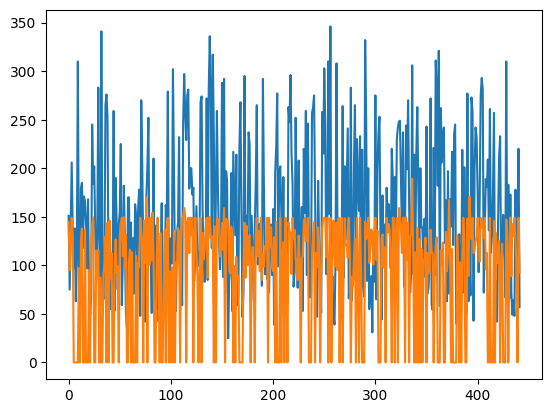

In [99]:
import matplotlib.pyplot as plt

y_preds = model.predict(X)

plt.plot(np.arange(y.shape[0]), y)
plt.plot(np.arange(y.shape[0]), y_preds)
plt.show()

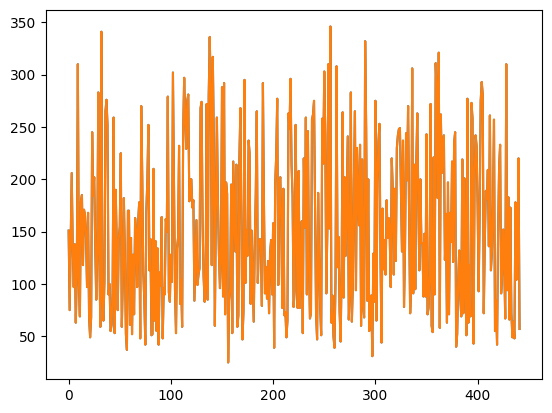

In [19]:
from sklearn.tree import DecisionTreeRegressor

model_sklearn = DecisionTreeRegressor()
model_sklearn.fit(X,y)

y_preds_sklearn = model_sklearn.predict(X)

plt.plot(np.arange(y.shape[0]), y)
plt.plot(np.arange(y.shape[0]), y_preds_sklearn)
plt.show()

### Next Thing TODO
- Figure out a way to debug our implementation.
- If we can plot the decision trees that were made that would be great.

### Identified Bug
- Write indices doesn't shrink - FIXED (But not fully FIXED)